In [2]:
from typing import Optional
import time
import os
import random

from PIL import Image
import PIL
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary as model_summary
import sklearn
from sklearn import model_selection

import monai
from monai.config import print_config

import torch
import torchvision as tv
import torch.nn as nn
from torch.nn import functional as F

In [3]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
monai.config.print_config()

torch.cuda.is_available(): True
torch.cuda.get_device_name(0): NVIDIA GeForce GTX 1660
torch.version.cuda: 12.1
torch.cuda.device_count(): 1

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.0
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.7
pandas version: NOT INSTALLED or UN

In [4]:
# 하이퍼 파라미터
RANDOM_SEED = 831
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 4
NUM_CLASS = 2
EPOCHS = 10

TEST_ratio = 0.1
VAL_ratio = 0.2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

root_path = 'C:/Users/Segmentation/Lung Segmentation'
model_save = False
if model_save:
    model_save_path = './FCN_v1.pth'
CXR_path = os.path.join(root_path, 'CXR_png')
MASK_path = os.path.join(root_path, 'masks')


In [5]:
CXR_list = sorted(os.listdir(CXR_path))
MASK_list = sorted(os.listdir(MASK_path))

In [6]:
MASK_list_ = list(map(lambda x:x.split('.')[0][:-5]+'.png', MASK_list))
CXR_MASK_union_list = set(MASK_list_) & set(CXR_list)
CXR_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'CXR_png', x), CXR_MASK_union_list)))
MASK_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'masks', x.split('.')[0]+'_mask.png'), CXR_MASK_union_list)))
print(len(CXR_path_list), CXR_path_list[:1])
print(len(MASK_path_list), MASK_path_list[:1])

566 ['C:/Users/Segmentation/Lung Segmentation\\CXR_png\\CHNCXR_0001_0.png']
566 ['C:/Users/Segmentation/Lung Segmentation\\masks\\CHNCXR_0001_0_mask.png']


In [7]:
X, X_test, y, y_test = model_selection.train_test_split(CXR_path_list, MASK_path_list, test_size=TEST_ratio, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=VAL_ratio, random_state=RANDOM_SEED)
print(len(X_train), len(X_val), len(X_test))

407 102 57


In [8]:
samplex = tv.io.read_image(X_train[0])
sampley = tv.io.read_image(y_train[0])
print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

torch.Size([1, 2946, 2994]) torch.uint8
torch.Size([1, 2946, 2994]) torch.uint8 [  0 255]


In [9]:
## 데이터 로더

class MyDataLoader(torch.utils.data.Dataset):

    def __init__(self, img_path, img_labels, transforms_x=None, transforms_y=None):
        self.img_path = img_path
        self.img_labels = img_labels
        self.transforms_x = transforms_x
        self.transforms_y = transforms_y

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, index):
        ten_x = tv.io.read_image(self.img_path[index])/255
        if ten_x.shape[0] == 3:
            ten_x = ten_x[:1]
            
        ten_y = tv.io.read_image(self.img_labels[index]).to(torch.int64)
        ten_y = ten_y.squeeze(dim=0)
        tenoh_y = OneHotEncoding(ten_y, num_classes=NUM_CLASS)

        if self.transforms_x:
            ten_x = self.transforms_x(ten_x)        
        if self.transforms_y:
            tenoh_y = self.transforms_y(tenoh_y)        
        
        ten_x = ten_x[0]
        ten_x = torch.stack([ten_x,ten_x,ten_x], dim=0)
        return ten_x, tenoh_y
    
    
def OneHotEncoding(labels, num_classes:int):
    shape = labels.shape
    label_oh = torch.zeros(*shape) 
    for cnt, i in enumerate(sorted(np.unique(labels))):
        i_mask = torch.where(labels == i, cnt, 0)
        i_mask.bool()
        label_oh.masked_fill_(i_mask.to(torch.bool), cnt) # 이부분 불텐서로 바꿔주기
    label_oh = F.one_hot(label_oh.to(torch.int64), num_classes=num_classes)
    label_oh = label_oh.permute(2,0,1).to(torch.float)
    return label_oh    


In [10]:
## Transforms and Check
train_x_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE)
])
train_y_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE)
])

val_x_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE)
])
val_y_transforms = tv.transforms.Compose([
    tv.transforms.Resize(size=IMAGE_SIZE)
])

In [11]:
train_ds = MyDataLoader(X_train, y_train,
                       transforms_x=train_x_transforms, transforms_y=train_y_transforms)
val_ds = MyDataLoader(X_val, y_val,
                      transforms_x=val_x_transforms, transforms_y=val_y_transforms)
test_ds = MyDataLoader(X_test, y_test,
                       transforms_x=val_x_transforms, transforms_y=val_y_transforms)

In [12]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [13]:
train_sample_x, train_sample_y = next(iter(train_loader))

In [14]:
print(f'train_sample_x.shape: {train_sample_x.shape}')
print(f'train_sample_x.dtpye: {train_sample_x.dtype}')
print(f'train_sample_x.min, max: {torch.min(train_sample_x), torch.max(train_sample_x)}')
print(f'train_sample_y.shape: {train_sample_y.shape}')
print(f'train_sample_y.dtpye: {train_sample_y.dtype}')
print(f'train_sample_y.min, max: {torch.min(train_sample_y), torch.max(train_sample_y)}')
print(f'train_sample_y.unique: {np.unique(train_sample_y)}')

train_sample_x.shape: torch.Size([4, 3, 224, 224])
train_sample_x.dtpye: torch.float32
train_sample_x.min, max: (tensor(0.0067), tensor(1.0000))
train_sample_y.shape: torch.Size([4, 2, 224, 224])
train_sample_y.dtpye: torch.float32
train_sample_y.min, max: (tensor(0.), tensor(1.0000))
train_sample_y.unique: [0.0000000e+00 1.0684738e-08 4.9670803e-08 ... 1.0000004e+00 1.0000005e+00
 1.0000006e+00]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


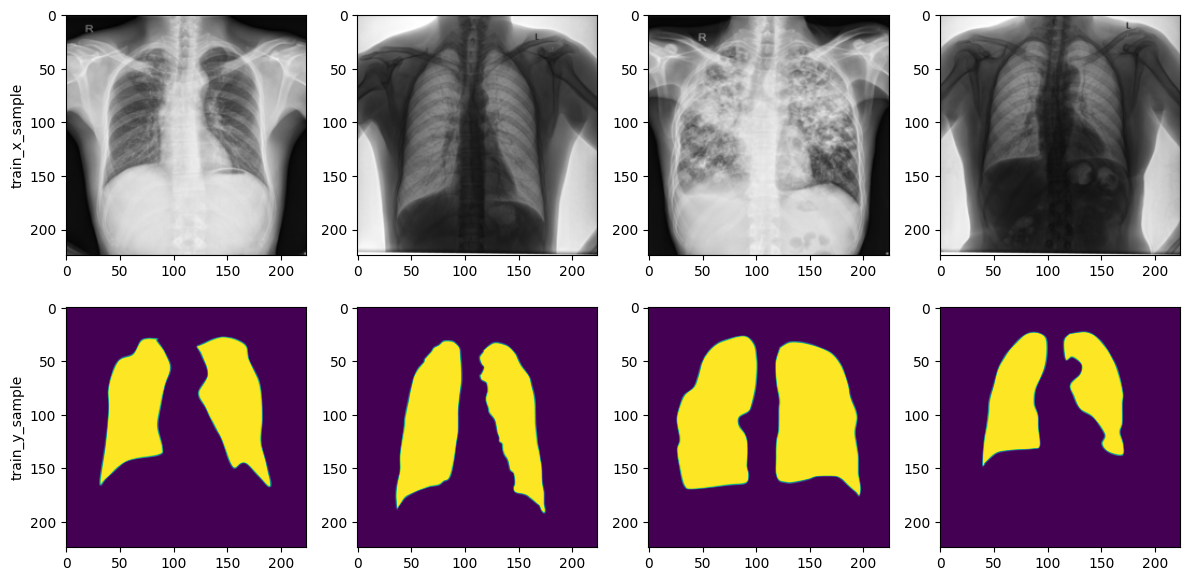

In [15]:
### VISUALIZE ###
ncols, nrows = 4, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    img0 = train_sample_x[i].permute(1,2,0)
    img1 = train_sample_y[i].permute(1,2,0)[:,:,-1]
    
    axes[0,i].imshow(img0)
    axes[0,0].set_ylabel('train_x_sample')
    
    axes[1,i].imshow(img1)
    axes[1,0].set_ylabel('train_y_sample')
plt.tight_layout()
plt.show()
###################################################

In [28]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 2, kernel_size=1)
        
    def forward(self, x):
        x = self.block1(x)
        x1 = x
        x = self.block2(x)
        x2 = x
        x = self.block3(x)
        x3 = x
        x = self.block4(x)
        x4 = x
        x = self.block5(x)
        x5 = x
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

model = FCN()
model_summary(model, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [30]:
import monai.metrics


model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=2e-4)

CE_LOSS = torch.nn.CrossEntropyLoss()

Metcric_dice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [31]:
def train(model, train_loader, optimizer):
    since = time.time()
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        step = batch_idx+1
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # 그라디언트를 새로 계산하기 위해 0으로 초기화
        output = model(data)
        loss = CE_LOSS(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        dice_output = torch.where(output>=0.5, 1, 0)
        Metcric_dice(y_pred=dice_output, y=target)

    epoch_loss = epoch_loss / step
    dice_score = Metcric_dice.aggregate().item()
    Metcric_dice.reset()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    return epoch_loss, dice_score


In [32]:
def evaluate(model, test_loader):
    model.eval() # 평가 모드
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            step = batch_idx+1
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            loss += CE_LOSS(output, target).item()
            dice_output = torch.where(output>=0.5, 1, 0)
            Metcric_dice(y_pred=dice_output, y=target)

    loss /= len(val_ds) # 전체 데이터셋의 길이
    dice_score = Metcric_dice.aggregate().item()
    Metcric_dice.reset()

    return loss, dice_score



In [34]:
losses = {'train':[], 'val':[]}
dice_scores = {'train':[], 'val':[]}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS+1):
    train_loss, train_dice_score = train(model, train_loader, optimizer)
    val_loss, val_dice_score = evaluate(model, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    print(f'[{epoch}] Train Loss: {train_loss:.6f}, Dice score: {train_dice_score:.6f}')
    print(f'[{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')
    
    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        if model_save:
            torch.save(model.state_dict(), model_save_path)
            print('saved model')

Training complete in 2m 15s
[1] Train Loss: 0.168909, Dice score: 0.821725
[1] Test Loss: 0.185594, Dice score: 0.818231
Training complete in 2m 14s
[2] Train Loss: 0.144803, Dice score: 0.839053
[2] Test Loss: 0.030564, Dice score: 0.855523
Training complete in 2m 13s
[3] Train Loss: 0.135571, Dice score: 0.849377
[3] Test Loss: 0.061376, Dice score: 0.385060
Training complete in 2m 13s
[4] Train Loss: 0.113267, Dice score: 0.874344
[4] Test Loss: 0.037715, Dice score: 0.913347
Training complete in 2m 14s
[5] Train Loss: 0.108049, Dice score: 0.882624
[5] Test Loss: 0.027595, Dice score: 0.849449
Training complete in 2m 13s
[6] Train Loss: 0.094828, Dice score: 0.902469
[6] Test Loss: 0.065432, Dice score: 0.565352
Training complete in 2m 14s
[7] Train Loss: 0.092999, Dice score: 0.901678
[7] Test Loss: 0.025171, Dice score: 0.930040
Training complete in 2m 23s
[8] Train Loss: 0.084449, Dice score: 0.913573
[8] Test Loss: 0.020152, Dice score: 0.908000
Training complete in 2m 23s
[9] 

In [35]:
print(f"train completed, best_metric: {best_metric:.4f} \n" 
      f"at epoch: {best_epoch}")

train completed, best_metric: 0.0197 
at epoch: 9


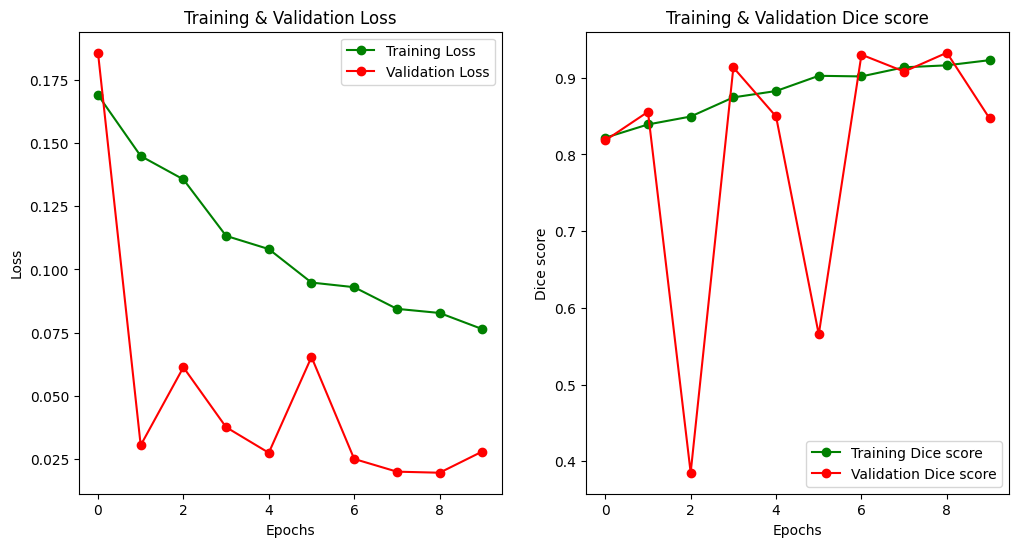

In [36]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_dice , 'go-' , label = 'Training Dice score')
ax[1].plot(epochs , val_dice , 'ro-' , label = 'Validation Dice score')
ax[1].set_title('Training & Validation Dice score')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice score")
plt.show()

In [37]:
test_ds = MyDataLoader(X_test, y_test, 
                      transforms_x=val_x_transforms, transforms_y=val_y_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)
len_test = len(test_loader)

pred_dict = {'input':[], 'target':[], 'output':[]}

if model_save:
    model.load_state_dict(torch.load(model_save_path))
model.to('cpu')
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to('cpu'), target.to('cpu')
        output = model(data).detach().cpu()
        output = torch.argmax(output, dim=1, keepdim=True)
        
        data_ = data[0].permute(1,2,0)
        target_ = target[0].permute(1,2,0)[:,:,-1]
        output_ = output[0].permute(1,2,0)[:,:,-1]
        
        pred_dict['input'].append(data_)
        pred_dict['target'].append(target_)
        pred_dict['output'].append(output_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


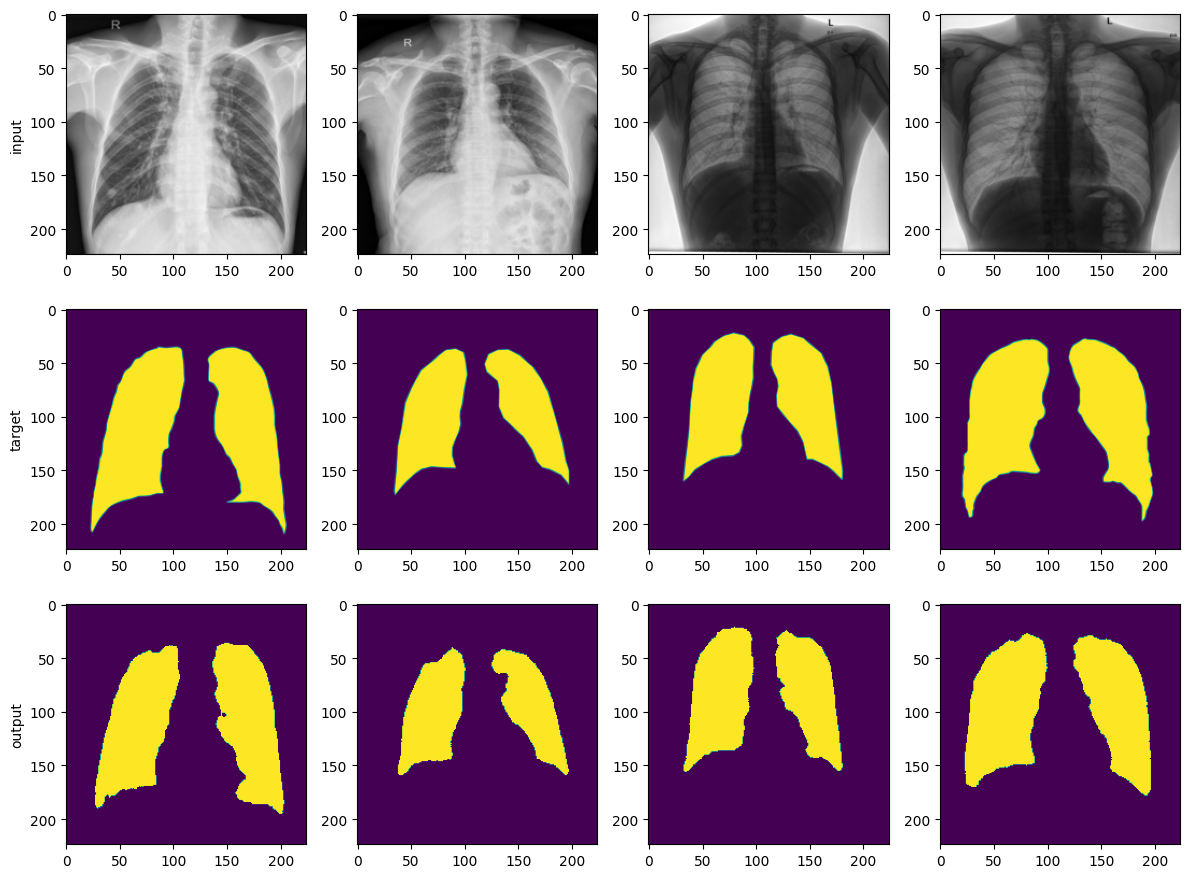

In [38]:
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    axes[0,i].imshow(pred_dict['input'][i])
    axes[0,0].set_ylabel('input')

    axes[1,i].imshow(pred_dict['target'][i])
    axes[1,0].set_ylabel('target')

    axes[2,i].imshow(pred_dict['output'][i])
    axes[2,0].set_ylabel('output')

plt.tight_layout()
plt.show()